In [4]:
#load the ADSQ task dataset
from scipy.io import loadmat

data = loadmat('data/ADSQ_data.mat')['data']
mzs = loadmat('data/ADSQ_mzs.mat')['mzs']
label = loadmat('data/ADSQ_label.mat')['label']
classes = loadmat('data/ADSQ_class.mat')['class'][0]

In [5]:
#construct a Pandas Dataframe using the above loaded data
import pandas as pd
import numpy as np

ADSQ_df = pd.DataFrame(data)
ADSQ_df.columns = np.round(mzs[0,:],2)
#Total ion current normalization (or L1 normalization)
tic = ADSQ_df.sum(1).values
ADSQ_df = np.divide(ADSQ_df,tic.reshape(tic.shape[0],1))
#delete the raw data to save some memory
del data

In [7]:
#shuffle the entire dataset to mix the samples
from sklearn.utils import shuffle
ADSQ_df.insert(0,'type',label)
ADSQ_df['type'] = ADSQ_df['type'].map({1:'AD',2:'SQ'})
ADSQ_df = ADSQ_df.sample(frac=1,random_state=9).reset_index(drop=True)
ADSQ_df.head()

,type,519.08,519.16,519.25,519.33,519.41,519.5,519.58,519.66,519.74,...,4958.85,4959.1,4959.34,4959.58,4959.82,4960.07,4960.31,4960.55,4960.8,4961.04
0,AD,0.000057,0.000061,0.000022,0.000016,0.000020,0.000006,0.000007,0.000000,0.000056,...,0.000016,0.000009,0.000004,0.000005,0.000005,0.000011,0.000020,2.617661e-05,0.000027,0.000013
1,AD,0.000079,0.000073,0.000047,0.000019,0.000011,0.000024,0.000020,0.000024,0.000021,...,0.000019,0.000003,0.000016,0.000007,0.000019,0.000031,0.000006,1.539961e-05,0.000003,0.000007
2,SQ,0.000084,0.000084,0.000047,0.000029,0.000042,0.000025,0.000045,0.000000,0.000000,...,0.000018,0.000026,0.000011,0.000022,0.000022,0.000005,0.000003,7.241437e-06,0.000022,0.000009
3,AD,0.000033,0.000108,0.000282,0.000117,0.000124,0.000061,0.000025,0.000013,0.000000,...,0.000035,0.000025,0.000011,0.000014,0.000016,0.000019,0.000010,7.514679e-07,0.000018,0.000032
4,SQ,0.000218,0.000126,0.000035,0.000076,0.000018,0.000021,0.000012,0.000017,0.000000,...,0.000005,0.000004,0.000022,0.000021,0.000012,0.000002,0.000008,1.318835e-05,0.000017,0.000014


In [7]:
ADSQ_df = pd.read_pickle('data/ADSQ_df.pkl')

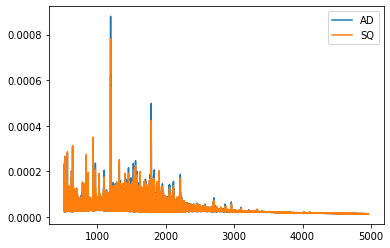

In [6]:
#visualize average spectrum
import matplotlib.pyplot as plt

plt.plot(mzs[0],ADSQ_df[ADSQ_df['type']=='AD'].mean(0),label='AD')
plt.plot(mzs[0],ADSQ_df[ADSQ_df['type']=='SQ'].mean(0),label='SQ')
plt.legend()

In [8]:
#split the dataset into training and test set

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

X_train, X_test, y_train, y_test = train_test_split(ADSQ_df.drop('type',1).values, 
                                                    ADSQ_df['type'], test_size=0.3,
                                                    random_state=19)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

y_train_ = y_train.map({'AD':0,'SQ':1})
y_test_ = y_test.map({'AD':0,'SQ':1})

lda = LinearDiscriminantAnalysis(solver='svd',n_components=1)
lda.fit(X_train,y_train)
y_pred_lda = lda.predict(X_test)
report_dict_lda = classification_report(y_test, y_pred_lda, output_dict=True)
#conf_mtx_lda = confusion_matrix(y_test, y_pred_lda)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lda,X=ADSQ_df.drop('type',1).values,y=ADSQ_df['type'],cv=5,n_jobs=8)
print(scores)

In [97]:
#Gradient boosting tree
import xgboost
xgb = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',subsample=1,
                            reg_alpha=0,min_child_weight=5,max_depth=4,gamma=0,colsample_bytree=1,nthread = 8)
xgb.fit(X_train,y_train)

y_pred_xgb = xgb.predict(X_test)
prob_xgb = xgb.predict_proba(X_test)
report_dict_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
report_dict_xgb

NameError: name 'report_dict_xgb' is not defined